<a href="https://colab.research.google.com/github/oliv-ia/C3-segmentation/blob/main/dice_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro


This is to start playing with the cropped training data. Want to try and load it into a pretrained NN.

In [ ]:
!pip install SimpleITK

this was from a youtube tutorial - may not need

In [ ]:
!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.8MB 23kB/s 
     |████████████████████████████████| 5.9MB 44.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


this one we do need.

In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 552kB 8.0MB/s 
     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 276kB 13.6MB/s 
     |████████████████████████████████| 829kB 15.1MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=cff57c2216ebd9ea0e9885d9214fb247809649cb069fea313507cb13aad6285d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=142a6dca3fe63f0f53b72b3bf1aeaab27642bae1d78755521e0aad85286d293b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninst

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import os
from scipy import ndimage
import cv2
from google.colab.patches import cv2_imshow
import torch

Function to print training data from the dictionary

In [ ]:
def printTrainingData(patient_number):
  if patient_number == 24 or patient_number == 25:
    print("not valid patient number")
  elif patient_number in range(1,28):
    if patient_number > 24: 
      patient_number = patient_number - 2
    print("HNSCC Patient " + str(ids[patient_number-1]))
    plt.imshow(slices[patient_number-1], cmap=plt.cm.gray, vmin=(level/2 - window), vmax=(level/2 + window))
    masks[patient_number-1][masks[patient_number-1] == 0] = np.nan
    plt.imshow(masks[patient_number-1], cmap=plt.cm.autumn, alpha = 0.4)
    plt.show()
  else:
    print("not valid patient number")

In [ ]:
def PrintTrainingDataLiv(slicef_array, maskf_array, idf_array, i ):
  print("HNSCC Patient " + str(idf_array[i]))
  plt.imshow(slicef_array[i], cmap = plt.cm.gray, vmin = level/2 - window, vmax = level/2 + window)
  seg_slice = maskf_array[i]
  seg_slice = seg_slice.astype(float)
  seg_slice[seg_slice == 0] = np.nan
  plt.imshow(seg_slice, cmap = plt.cm.autumn, alpha = 0.6)

In [ ]:
def printTrainingDataForPatient(patient_number):
  if patient_number == 24 or patient_number == 25: 
    print("not valid patient number")
  elif patient_number in range(1,28):
    if patient_number > 25: 
      patient_number = patient_number - 2
    print("HNSCC Patient " + str(id_array[patient_number-1]))
    plt.imshow(slices_array[patient_number-1], cmap=plt.cm.gray, vmin=(level/2 - window), vmax=(level/2 + window))
    mask_array[patient_number-1][mask_array[patient_number-1] == 0] = np.nan
    plt.imshow(mask_array[patient_number-1], cmap=plt.cm.autumn, alpha = 0.4)
    plt.show()
  else:
    print("not valid patient number")

Function to determine the average pixel value within the segment

In [ ]:
def AveragePixelValue(patient_number):
  tot_segmented_pixels_value = 0;
  slices = data['slices']
  masks = data['masks']
  ids = data['ids']
  if patient_number == 24 or patient_number == 25:
    print("not valid patient number")
  elif patient_number in range(1,28):
    #for i in range(0,len(masks[patient_number - 1])):
    for i in np.nditer(masks[patient_number - 1], order = 'C'):
      if i != 0:
        val = np.sum(slices[patient_number-1][int(i)])
      #if masks[patient_number-1][i != 0]:
        tot_segmented_pixels_value += slices[patient_number-1][int(i)]
  else:
    print("not valid patient number")
  print(val/len(masks[patient_number - 1]))
  return tot_segmented_pixels_value
  


Dice evaluator from Andrew. 

In [ ]:
def eval_dice(true, pred):
    evaluator = sitk.LabelOverlapMeasuresImageFilter()
    a_t_im = sitk.GetImageFromArray(true)
    t_p_im = sitk.GetImageFromArray(pred)
    evaluator.Execute(a_t_im, t_p_im)#a_t_im, t_p_im
    return evaluator.GetDiceCoefficient()


Liv's dice eval function that she found on the internet (get link)

In [ ]:
def diceCoeff(pred, gt, smooth=1, activation='sigmoid'):
    r""" computational formula：
        dice = (2 * (pred ∩ gt)) / (pred ∪ gt)
    """
 
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
                 raise NotImplementedError("Activation implemented for sigmoid and softmax2d activation function operation")
 
    pred = activation_fn(pred)
 
    N = gt.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)
 
    intersection = (pred_flat * gt_flat).sum(1)
    unionset = pred_flat.sum(1) + gt_flat.sum(1)
    
    loss = (2 * intersection + smooth) / (unionset + smooth)
 
    return loss.sum() / N

Set the window and level here. 50:350HU for soft tissue

#Dice Evaluator
 

In [ ]:
data = np.load("/content/training_data_cropped.npz", allow_pickle=True)

In [ ]:
slices_h = data['slices']
masks_h = data['masks']
ids_h = data['ids']

In [ ]:
data_liv = np.load("/content/liv_training_data_cropped.npz", allow_pickle=True)
slices_L = data_liv['slices']
masks_L = data_liv['masks']
ids_L = data_liv['ids']

compare mine and Liv's segs

In [ ]:
print(masks_L[1].dtype)
print(masks_L[0].shape)
plt.imshow(masks_L[1])
masks = masks.astype(np.int8)
eval_dice(masks[1], masks[2])
import torch
Masks_L = torch.from_numpy(masks_L.astype(np.int16))
Masks_H = torch.from_numpy(masks_H.astype(np.int16))
#eval_dice(masks_L[1], masks_L[1])
print((Masks_H[2].dtype))

print(Masks_L[2].dtype)
dice_array = []
dice_c = diceCoeff(Masks_H[:, 0:1, :], Masks_L[:, 0:1, :], smooth=1, activation=None)
for i in range(0,25):
   dice_b = diceCoeff(Masks_H[i], Masks_L[i], smooth=1, activation=None)
   print(i , 'smooth=1 : dice={:.4}'.format(dice_b.item()))
   dice_array.append(dice_b.item())

print(dice_array)
mean = sum(dice_array)/len(dice_array)
print(mean)

Printing the training data

HNSCC Patient 01-0013


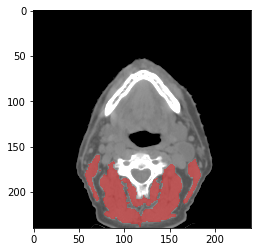

In [ ]:
printTrainingData(13)